In [1]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# get data
data = pd.read_pickle("./data/datasets/islets_rna_prot_dataset.pkl")
sample_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_sample_metadata.pkl")
feature_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_feature_metadata.pkl")

sys.path.append("src.py")
from src import Utils

### [F04] Replicate correlations for transcriptomics and proteomics

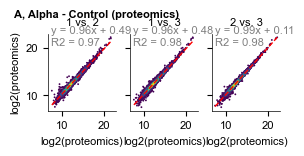

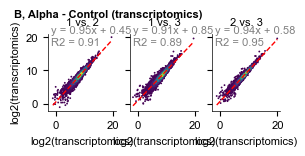

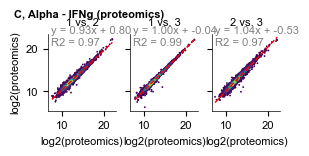

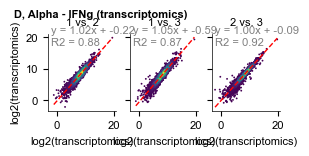

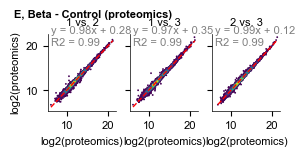

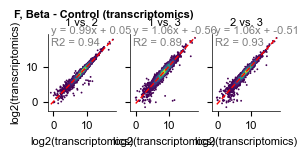

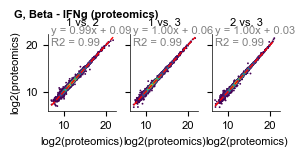

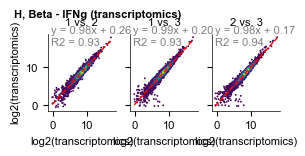

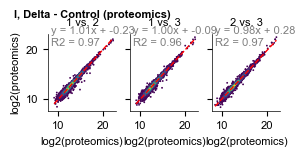

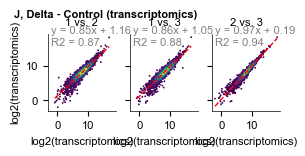

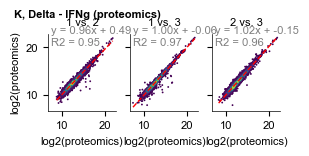

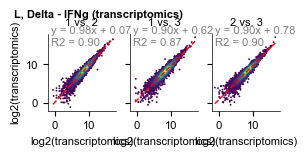

In [2]:
def scatter_melt(
    data: pd.DataFrame,
    sample_metadata: pd.DataFrame,
    pairs: list = None,
    md_lookup_col: str = None,
    md_columns_to_keep: list = None,
    expected_length: int = None,
    aggregation: str = None,
):
    """Melt data for scatterplotting"""

    sample_metadata['_index'] = sample_metadata.index

    # melt data
    pair_datasets = []
    for pair_tuple in pairs:

        k = pair_tuple[0]
        v = pair_tuple[1]
        
        # coerce k and v to lists
        k_list = [k] if isinstance(k, str) else k
        v_list = [v] if isinstance(v, str) else v
        
        # get data
        g1_idx = sample_metadata[sample_metadata[md_lookup_col].isin(k_list)].index
        g2_idx = sample_metadata[sample_metadata[md_lookup_col].isin(v_list)].index

        # check data length
        if expected_length is not None:
            if len(g1_idx) != expected_length or len(g2_idx) != expected_length:
                raise ValueError(f"Expected length of 1, got {len(g1_idx)} for {k} and {len(g2_idx)} for {v}")

        # get data
        g1_df = data.loc[g1_idx].T
        g2_df = data.loc[g2_idx].T

        # aggregate data if specified
        if aggregation == 'mean':
            g1_df = g1_df.mean(axis = 1).to_frame(name = 'value')
            g2_df = g2_df.mean(axis = 1).to_frame(name = 'value')

        # check: dataframes must have only one column
        if g1_df.shape[1] != 1 or g2_df.shape[1] != 1:
            raise ValueError("Dataframes must have only one column, check aggregation and input pairs")

        # rename columns
        g1_df.columns = ['value']
        g2_df.columns = ['value']

        # add subsequent columns to dataframes
        g1_df['var'] = k
        g1_df['idx'] = ';'.join(g1_idx.values)

        g2_df['var'] = v
        g2_df['idx'] = ';'.join(g2_idx.values)

        # output metadata: get column values
        # e.g. for coloring by replicate
        for col in md_columns_to_keep:
            g1_df[col] = ';'.join(sample_metadata.loc[g1_idx, col].tolist())
            g2_df[col] = ';'.join(sample_metadata.loc[g2_idx, col].tolist())

        # merge with suffix
        out_df = g1_df.merge(g2_df, how = 'inner', left_index = True, right_index = True, suffixes = ('_x', '_y'))
        pair_datasets.append(out_df)

    # concatenate and return
    return pd.concat(pair_datasets)

def suppl_figure_5_inter_replicate_scatterplots(
        sf_51_ds : pd.DataFrame = None,
        pairs : list = None
):
    # iterate over pairs of sample and treatment, plot replicate pairs as scatterplots
    
    # make A, B, C... labels as long as pairs
    def _alphabetic_range(len: int):
        return [chr(i) for i in range(65, 65 + len)]
    indices = _alphabetic_range(len(pairs))

    # iterate over all sample-treatment-readout combinations
    plot_element_filters = []
    for sample in ['alpha', 'beta', 'delta']:
        for treatment in ['control', 'ifng']:
            for readout in ['proteomics', 'transcriptomics']:
                plot_element_filters.append((sample, treatment, readout))

    r2_scores = {}
    for plot_element, plot_element_filter in zip(indices, plot_element_filters):

        sample = plot_element_filter[0]
        treatment = plot_element_filter[1]
        readout = plot_element_filter[2]

        plot_df = sf_51_ds[
            (sf_51_ds['sample_x'] == sample) &
            (sf_51_ds['treat_x'] == treatment) &
            (sf_51_ds['readout_x'] == readout) &
            (sf_51_ds['sample_y'] == sample) &
            (sf_51_ds['treat_y'] == treatment) &
            (sf_51_ds['readout_y'] == readout)
        ]
        
        # plot

        # replace the value_x and value_y labels with the respective value labels
        label_parse_dict = {
            'value_x' : f'log2({readout})',
            'value_y' : f'log2({readout})',
        }

        def label_parse_regex(l):
            l = l.replace('alpha', 'Alpha')
            l = l.replace('beta', 'Beta')
            l = l.replace('delta', 'Delta')
            l = l.replace('control', 'Control')
            l = l.replace('ifng', 'IFNg')
            l = l.replace('_', ' vs. ')

            return l

        f, a, r2dict = Utils.scatter(
            data = plot_df, 
            x_col = 'value_x',
            y_col = 'value_y',
            color_column = 'rep_pair',
            segments = 'facets',
            linear_regression = True,
            xlabel = None,
            ylabel = None,
            density = True,
            show_equation = True,
            enumerate_plot = f"{plot_element}, {sample} - {treatment} ({readout})",
            label_lookup_dict = label_parse_dict,
            facet_titles = True,
            label_general_regex = label_parse_regex,
            scatter_kwargs = {'s': 7},
            figsize_x = 3,
            figsize_y = 1,
            return_linear_regression = True,
        )

        # save plot
        Utils.save_figure(
            fig = f, 
            filename = f"fig_04_inter_replicate_scatterplot_{sample}_{treatment}_{readout}_new.svg",
            output_dir = "./assets/20250423_revision_figures/",
            dpi = 300,
            paper_width = "1.5",
            paper_height = "0.5",
            transparency = False,
        )

        # store r2 values
        r2_scores[f"{sample}_{treatment}_{readout}"] = r2dict

    return r2_scores

# create pairs: 12 dataframes for each sample-treatment-readout combination
# each dataframe contains three replicate-comparisons for faceted plotting
pairs = []
for sample in ['alpha', 'beta', 'delta']:
    for treatment in ['control', 'ifng']:
        for readout in ['proteomics', 'transcriptomics']:
            for rep_pair in [('1', '2'), ('1', '3'), ('2', '3')]:
                p1 = '_'.join([sample, treatment, rep_pair[0], readout])
                p2 = '_'.join([sample, treatment, rep_pair[1], readout])
                pairs.append((p1, p2))

sf_51_ds = scatter_melt(
    data = data,
    sample_metadata = sample_metadata,
    pairs = pairs,
    md_lookup_col = '_index',
    md_columns_to_keep = ['rep', 'sample', 'treat', 'readout'],
    expected_length = 1)

sf_51_ds['rep_pair'] = sf_51_ds['rep_x'] + '_' + sf_51_ds['rep_y']

r2_values = suppl_figure_5_inter_replicate_scatterplots(sf_51_ds, pairs)

proteomics r2: 0.9765501795608303
proteomics r2: 0.9078862255995163


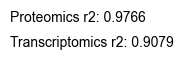

In [3]:
# proteomics r2
Rs_p = [list(v[0].values()) for k, v in r2_values.items() if 'proteomics' in k]
Rs_p = [item for sublist in Rs_p for item in sublist]
print(f'proteomics r2: {np.mean(Rs_p)}')

# transcriptomics r2
Rs_t = [list(v[0].values()) for k, v in r2_values.items() if 'transcriptomics' in k]
Rs_t = [item for sublist in Rs_t for item in sublist]
print(f'proteomics r2: {np.mean(Rs_t)}')

fig, ax = plt.subplots(figsize = (2, 0.8))
ax.axis('off')
ax.text(0, 0.8, f'Proteomics r2: {np.mean(Rs_p):.4f}', fontsize = 10)
ax.text(0, 0.4, f'Transcriptomics r2: {np.mean(Rs_t):.4f}', fontsize = 10)
plt.savefig(
    './assets/20250423_revision_figures/fig_04_inter_replicate_scatterplot_r2.svg',
    dpi = 300,
    bbox_inches = 'tight',
    transparent = True,
)